# Sentinel-1/2 Terrain Classification Pipeline
## Multi-Modal SAR + Optical Data Training

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import rasterio
from tqdm import tqdm
import tensorflow as tf

# Configuration
DATA_DIR = r"D:\My Disk\coding\v_2"
CLASSES = ['agri', 'barrenland', 'grassland', 'urban']
BATCH_SIZE = 16
IMG_SIZE = 256  # All images will be resized to this
EPOCHS = 50

C:\Users\len\.conda\envs\sarproject\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 1. Data Loading & Preprocessing

def load_and_preprocess_data():
    """Loads S1 (uncolored) and S2 (colored) images with terrain labels"""
    X_s1, X_s2, y = [], [], []
    
    for class_idx, terrain in enumerate(CLASSES):
        s1_dir = os.path.join(DATA_DIR, terrain, 's1')
        s2_dir = os.path.join(DATA_DIR, terrain, 's2')
        
        print(f"Loading {terrain} data...")
        
        # Get matching filenames (assuming same names in s1/s2 folders)
        s1_files = [f for f in os.listdir(s1_dir) if f.endswith('.png')]
        
        for s1_file in tqdm(s1_files):
            # Load Sentinel-1 (SAR) image
            with rasterio.open(os.path.join(s1_dir, s1_file)) as src:
                s1_img = src.read()
                s1_img = np.moveaxis(s1_img, 0, -1)  # Channels last
                
            # Load corresponding Sentinel-2 (Optical) image
            s2_file = os.path.join(s2_dir, s1_file.replace('_s1', '_s2'))
            with rasterio.open(s2_file) as src:
                s2_img = src.read()
                s2_img = np.moveaxis(s2_img, 0, -1)
            
            # Resize if needed (using OpenCV if available)
            if s1_img.shape[0] != IMG_SIZE or s1_img.shape[1] != IMG_SIZE:
                import cv2
                s1_img = cv2.resize(s1_img, (IMG_SIZE, IMG_SIZE))
                s2_img = cv2.resize(s2_img, (IMG_SIZE, IMG_SIZE))
            
            # Normalize
            s1_img = (s1_img - np.min(s1_img)) / (np.max(s1_img) - np.min(s1_img))
            s2_img = s2_img / 255.0  # Assuming 8-bit RGB
            
            X_s1.append(s1_img)
            X_s2.append(s2_img)
            y.append(class_idx)
    
    return np.array(X_s1), np.array(X_s2), to_categorical(np.array(y))

In [5]:
import h5py  # For efficient storage

def process_and_save_class(terrain, class_idx, data_dir, img_size=256):
    """
    Processes all S1/S2 images for one terrain class and saves to .h5 file.
    Returns the count of processed samples.
    """
    s1_dir = os.path.join(data_dir, terrain, 's1')
    s2_dir = os.path.join(data_dir, terrain, 's2')
    os.makedirs('temp_data', exist_ok=True)
    output_path = f'temp_data/{terrain}.h5'
    
    s1_files = [f for f in os.listdir(s1_dir) if f.endswith('.png')]
    X_s1 = []
    X_s2 = []
    
    for s1_file in tqdm(s1_files, desc=f"Processing {terrain}"):
        # Load S1
        with rasterio.open(os.path.join(s1_dir, s1_file)) as src:
            s1_img = np.moveaxis(src.read(), 0, -1)
        # Load S2 (assumes matching filename)
        s2_file = s1_file.replace('_s1', '_s2')
        with rasterio.open(os.path.join(s2_dir, s2_file)) as src:
            s2_img = np.moveaxis(src.read(), 0, -1)
        
        # Resize if needed
        if s1_img.shape[0] != img_size:
            import cv2
            s1_img = cv2.resize(s1_img, (img_size, img_size))
            s2_img = cv2.resize(s2_img, (img_size, img_size))
        
        # Normalize
        s1_img = 10 * np.log10(np.clip(s1_img, 1e-6, None))  # Convert to dB
        s1_img = (s1_img + 50) / 50  # Scale typical SAR values (-50 to 0 dB)

        # For Optical (S2) - standard 0-1 normalization
        s2_img = np.clip(s2_img, 0, 10000) / 10000  # Sentinel-2 has 0-10000 range
        
        X_s1.append(s1_img)
        X_s2.append(s2_img)
    
    # Save to HDF5 (efficient binary format)
    with h5py.File(output_path, 'w') as hf:
        hf.create_dataset('X_s1', data=np.array(X_s1))
        hf.create_dataset('X_s2', data=np.array(X_s2))
        hf.create_dataset('y', data=np.full(len(X_s1), class_idx))
    
    return len(X_s1)

In [6]:
def load_all_classes(classes):
    """Loads preprocessed data from .h5 files and combines them."""
    X_s1, X_s2, y = [], [], []
    for class_idx, terrain in enumerate(classes):
        with h5py.File(f'temp_data/{terrain}.h5', 'r') as hf:
            X_s1.append(hf['X_s1'][:])
            X_s2.append(hf['X_s2'][:])
            y.append(hf['y'][:])
    
    # Combine all classes and convert labels to categorical
    X_s1_combined = np.concatenate(X_s1)
    X_s2_combined = np.concatenate(X_s2)
    y_combined = to_categorical(np.concatenate(y))
    
    return X_s1_combined, X_s2_combined, y_combined

In [ ]:
# Process one class at a time (saves to disk automatically)
for class_idx, terrain in enumerate(CLASSES):
    count = process_and_save_class(terrain, class_idx, DATA_DIR, IMG_SIZE)
    print(f"Processed {count} samples for {terrain}")

C:\Users\len\.conda\envs\sarproject\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing agri: 100%|█████████████████████████████████████████████████████████████| 4000/4000 [04:43<00:00, 14.13it/s]


Processed 4000 samples for agri


Processing barrenland:  59%|████████████████████████████████▍                      | 2362/4000 [01:37<00:28, 58.08it/s]

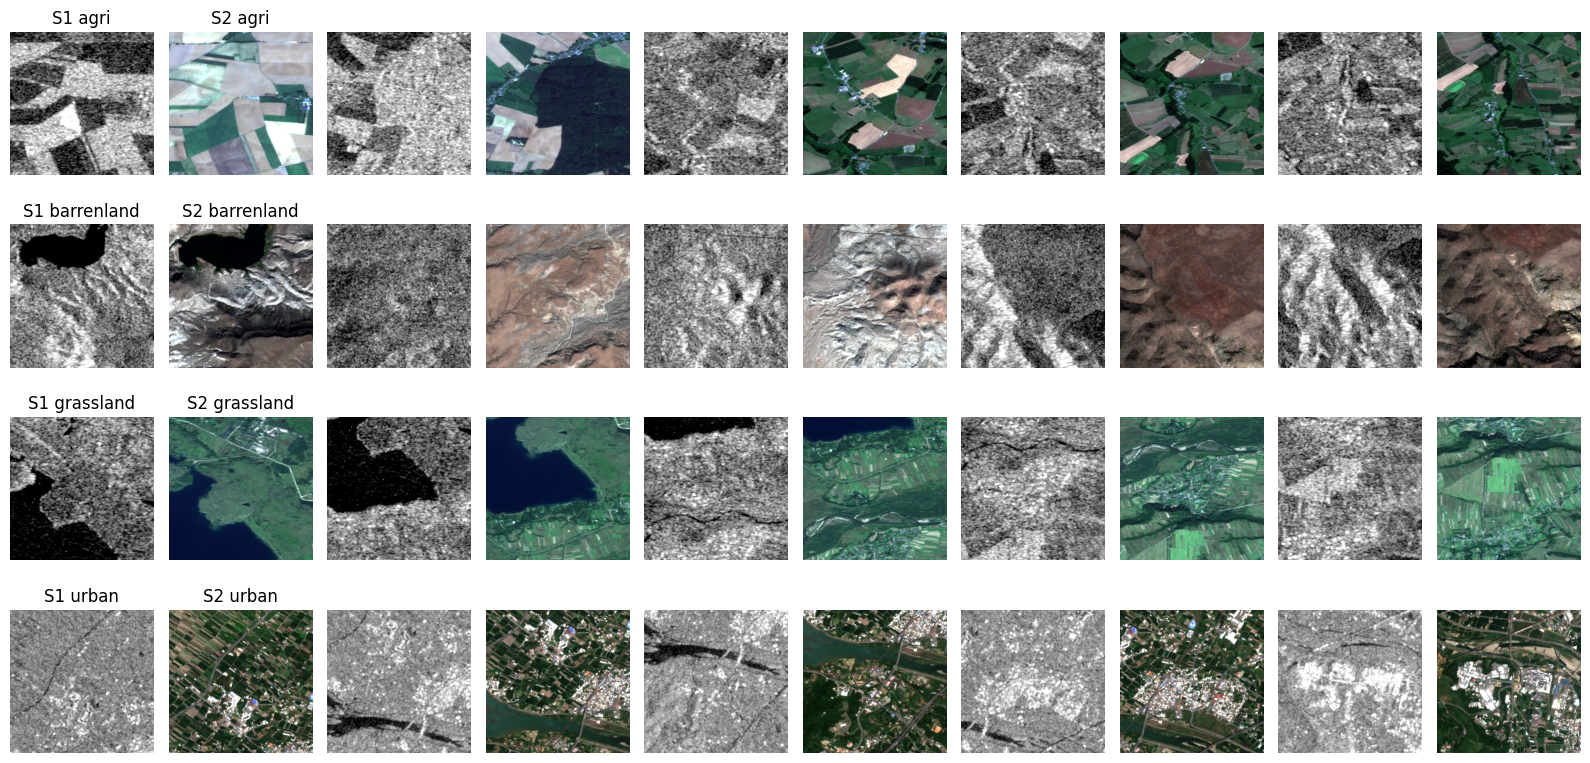

In [12]:
def visualize_samples_from_h5(classes, n_samples=5):
    """Visualizes samples directly from .h5 files without full loading"""
    plt.figure(figsize=(16, 8))
    
    for i, terrain in enumerate(classes):
        with h5py.File(f'temp_data/{terrain}.h5', 'r') as hf:
            # Load just a few samples per class
            s1_sample = hf['X_s1'][:n_samples]
            s2_sample = hf['X_s2'][:n_samples]
            y_sample = hf['y'][:n_samples]
            
            for j in range(n_samples):
                # SAR plot
                plt.subplot(len(classes), n_samples*2, i*(n_samples*2) + j*2 + 1)
                plt.imshow(s1_sample[j][:, :, 0], cmap='gray')
                plt.title(f"S1 {terrain}" if j==0 else "")
                plt.axis('off')
                
                # Optical plot
                plt.subplot(len(classes), n_samples*2, i*(n_samples*2) + j*2 + 2)
                if s2_sample[j].shape[-1] >= 3:
                    plt.imshow(s2_sample[j][:, :, :3])
                else:
                    plt.imshow(s2_sample[j][:, :, 0], cmap='viridis')
                plt.title(f"S2 {terrain}" if j==0 else "")
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage (visualizes 5 samples per class)
visualize_samples_from_h5(CLASSES, n_samples=5)

In [ ]:
# Load your batch-processed data
X_s1, X_s2, y = load_all_classes(CLASSES)  # Using your saved .h5 files

# Split data (keep this identical to your original)
X_s1_train, X_s1_test, X_s2_train, X_s2_test, y_train, y_test = train_test_split(
    X_s1, X_s2, y, test_size=0.2, random_state=42)

print(f"\nData Verification:")
print(f"SAR shape: {X_s1_train.shape}, Optical shape: {X_s2_train.shape}")
print(f"Class distribution in training set: {np.sum(y_train, axis=0)}")

# Enhanced visualization
plt.figure(figsize=(16, 8))

# SAR sample (show all channels if available)
plt.subplot(141)
plt.imshow(X_s1_train[0][:, :, 0], cmap='gray')  # First SAR channel
plt.colorbar()
plt.title(f"S1 SAR\n{CLASSES[np.argmax(y_train[0])]}\nShape: {X_s1_train[0].shape}")

# Optical sample (RGB)
plt.subplot(142)
if X_s2_train[0].shape[-1] >= 3:  # If has at least 3 channels
    plt.imshow(X_s2_train[0][:, :, :3])  # Show first 3 as RGB
else:
    plt.imshow(X_s2_train[0][:, :, 0], cmap='viridis')  # Single channel
plt.colorbar()
plt.title(f"S2 Optical\nShape: {X_s2_train[0].shape}")

# SAR histogram
plt.subplot(143)
plt.hist(X_s1_train[0].ravel(), bins=50, color='blue', alpha=0.7)
plt.title("SAR Pixel Values")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

# Optical histogram
plt.subplot(144)
plt.hist(X_s2_train[0].ravel(), bins=50, color='green', alpha=0.7)
plt.title("Optical Pixel Values")
plt.xlabel("Intensity")

plt.tight_layout()
plt.show()

# (ignore this batch) Load all data
X_s1, X_s2, y = load_and_preprocess_data()

# Split data
X_s1_train, X_s1_test, X_s2_train, X_s2_test, y_train, y_test = train_test_split(
    X_s1, X_s2, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_s1_train)}")
print(f"Test samples: {len(X_s1_test)}")

# Visualize samples
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_s1_train[0][:,:,0], cmap='gray')
plt.title(f"SAR Sample ({CLASSES[np.argmax(y_train[0])]})")
plt.subplot(122)
plt.imshow(X_s2_train[0])
plt.title(f"Optical Sample")
plt.show()

## 2. Multi-Input CNN Model Architecture

"""def create_multi_input_model(input_shape_s1, input_shape_s2, num_classes):
    # SAR data input branch
    s1_input = layers.Input(shape=input_shape_s1, name='sar_input')
    x1 = layers.Conv2D(32, (3,3), activation='relu')(s1_input)
    x1 = layers.MaxPooling2D((2,2))(x1)
    x1 = layers.Conv2D(64, (3,3), activation='relu')(x1)
    x1 = layers.MaxPooling2D((2,2))(x1)
    x1 = layers.Conv2D(128, (3,3), activation='relu')(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)
    
    # Optical data input branch
    s2_input = layers.Input(shape=input_shape_s2, name='optical_input')
    x2 = layers.Conv2D(32, (3,3), activation='relu')(s2_input)
    x2 = layers.MaxPooling2D((2,2))(x2)
    x2 = layers.Conv2D(64, (3,3), activation='relu')(x2)
    x2 = layers.MaxPooling2D((2,2))(x2)
    x2 = layers.Conv2D(128, (3,3), activation='relu')(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    
    # Combined features
    combined = layers.concatenate([x1, x2])
    
    # Classifier
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(64, activation='relu')(z)
    outputs = layers.Dense(num_classes, activation='softmax')(z)
    
    return models.Model(inputs=[s1_input, s2_input], outputs=outputs)

# Create model
model = create_multi_input_model(
    input_shape_s1=(IMG_SIZE, IMG_SIZE, X_s1.shape[-1]),
    input_shape_s2=(IMG_SIZE, IMG_SIZE, X_s2.shape[-1]),
    num_classes=len(CLASSES))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()"""

In [19]:
def create_enhanced_model(input_shape_s1, input_shape_s2, num_classes):
    # SAR Branch (using Conv2D with padding='same' to preserve dimensions)
    s1_input = layers.Input(shape=input_shape_s1, name='sar_input')
    x1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(s1_input)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D((2,2))(x1)
    
    x1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D((2,2))(x1)
    
    x1 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)

    # Optical Branch
    s2_input = layers.Input(shape=input_shape_s2, name='optical_input')
    x2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(s2_input)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D((2,2))(x2)
    
    x2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D((2,2))(x2)
    
    x2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)

    # Combined with attention
    combined = layers.concatenate([x1, x2])
    combined = layers.Dense(256, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    
    # Classifier
    outputs = layers.Dense(num_classes, activation='softmax')(combined)
    
    return models.Model(inputs=[s1_input, s2_input], outputs=outputs)

## 3. Training with Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

# Custom generator for multi-input data
def multi_input_generator(X_s1, X_s2, y, batch_size):
    gen_s1 = train_datagen.flow(X_s1, y, batch_size=batch_size, seed=42)
    gen_s2 = train_datagen.flow(X_s2, y, batch_size=batch_size, seed=42)
    while True:
        X1_batch, y_batch = gen_s1.next()
        X2_batch, _ = gen_s2.next()
        yield [X1_batch, X2_batch], y_batch

# Train model
history = model.fit(
    multi_input_generator(X_s1_train, X_s2_train, y_train, BATCH_SIZE),
    steps_per_epoch=len(X_s1_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_s1_test, X_s2_test], y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ])

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1. Enhanced Data Augmentation (applied to BOTH modalities consistently)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

# 2. Memory-Efficient Paired Augmentation Generator
def paired_augmentation_generator(h5_paths, batch_size=16):
    while True:
        # Select random class file
        h5_path = np.random.choice(h5_paths)
        
        with h5py.File(h5_path, 'r') as hf:
            # Get random indices for batch
            idxs = np.random.choice(len(hf['X_s1']), size=batch_size)
            
            # Load batch
            X_s1_batch = hf['X_s1'][idxs]
            X_s2_batch = hf['X_s2'][idxs]
            y_batch = hf['y'][idxs]
            
            # Apply THE SAME augmentation to both modalities
            seed = np.random.randint(1e6)
            
            # SAR augmentation
            g_s1 = train_datagen.flow(
                X_s1_batch, y_batch,
                batch_size=batch_size,
                seed=seed)
            
            # Optical augmentation (same seed!)
            g_s2 = train_datagen.flow(
                X_s2_batch, y_batch, 
                batch_size=batch_size,
                seed=seed)
            
            yield [next(g_s1)[0], next(g_s2)[0]], to_categorical(y_batch)

# 3. Callbacks with Learning Rate Adjustment
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('enhanced_model.h5', save_best_only=True)
]

# 4. Initialize generatorsS
train_h5_paths = [f'temp_data/{c}.h5' for c in CLASSES]
train_gen = paired_augmentation_generator(train_h5_paths, BATCH_SIZE)

# For validation (no augmentation)
def validation_generator(h5_paths, batch_size=16):
    while True:
        for h5_path in h5_paths:
            with h5py.File(h5_path, 'r') as hf:
                X_s1 = hf['X_s1'][:]
                X_s2 = hf['X_s2'][:]
                y = to_categorical(hf['y'][:])
                yield [X_s1, X_s2], y

val_gen = validation_generator(train_h5_paths)  # Or use separate val files

# 5. Train the enhanced model
history = model.fit(
    train_gen,
    steps_per_epoch=100,  # Adjust based on dataset size
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=20,
    callbacks=callbacks
)

NameError: name 'model' is not defined

## 4. Evaluation & Visualization

In [ ]:
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Classification report
y_pred = model.predict([X_s1_test, X_s2_test])
print(classification_report(np.argmax(y_test, axis=1),
                            np.argmax(y_pred, axis=1),
                            target_names=CLASSES))

## 5. Grad-CAM Visualization (Interpretability)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Adapted from Keras documentation for multi-input models"""
    # Create sub-model that outputs the last conv layer and predictions
    grad_model = models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Visualize for a test sample
sample_idx = 10
last_conv_layer_name = "conv2d_2"  # Change based on your model summary

# Generate heatmap
heatmap = make_gradcam_heatmap(
    [X_s1_test[sample_idx:sample_idx+1], X_s2_test[sample_idx:sample_idx+1]],
    model,
    last_conv_layer_name
)

# Display
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(X_s1_test[sample_idx][:,:,0], cmap='gray')
plt.title("SAR Input")
plt.subplot(132)
plt.imshow(X_s2_test[sample_idx])
plt.title("Optical Input")
plt.subplot(133)
plt.imshow(heatmap, cmap='jet')
plt.title("Class Activation Map")
plt.show()

In [27]:
import tensorflow as tf

NUM_CLASSES = 10  # Change this to your actual number of classes

train_dataset = tf.data.Dataset.from_generator(
    lambda: paired_augmentation_generator(train_h5_paths, BATCH_SIZE),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),  # X_s1
            tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),  # X_s2
        ),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)     # y
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator(train_h5_paths, BATCH_SIZE),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
)


In [28]:
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Constants
IMG_SHAPE = (64, 64, 3)  # Change if needed
NUM_CLASSES = 4
BATCH_SIZE = 16
EPOCHS = 50
CLASSES = ['agri', 'barrenland', 'grassland', 'urban']
train_h5_paths = [f'temp_data/{c}.h5' for c in CLASSES]

# 1. Define the Multi-Modal CNN Model
def build_multimodal_model(input_shape=(64, 64, 3), num_classes=4):
    def cnn_branch(input_tensor):
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
        x = BatchNormalization()(x)
        x = MaxPooling2D()(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D()(x)

        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = GlobalAveragePooling2D()(x)
        return x

    input_sar = Input(shape=input_shape)
    input_optical = Input(shape=input_shape)

    features_sar = cnn_branch(input_sar)
    features_optical = cnn_branch(input_optical)

    merged = Concatenate()([features_sar, features_optical])
    x = Dense(256, activation='relu')(merged)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[input_sar, input_optical], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_multimodal_model(IMG_SHAPE, NUM_CLASSES)

# 2. Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# 3. Paired Augmentation Generator
def paired_augmentation_generator(h5_paths, batch_size=16):
    while True:
        h5_path = np.random.choice(h5_paths)
        with h5py.File(h5_path, 'r') as hf:
            idxs = np.random.choice(len(hf['X_s1']), size=batch_size, replace=False)
            idxs.sort()  # ✅ HDF5 requires sorted indices
            
            X_s1_batch = hf['X_s1'][idxs]
            X_s2_batch = hf['X_s2'][idxs]
            y_batch = hf['y'][idxs]

            seed = np.random.randint(1e6)
            g_s1 = train_datagen.flow(X_s1_batch, y_batch, batch_size=batch_size, seed=seed)
            g_s2 = train_datagen.flow(X_s2_batch, y_batch, batch_size=batch_size, seed=seed)

            yield [next(g_s1)[0], next(g_s2)[0]], to_categorical(y_batch, num_classes=NUM_CLASSES)


# 4. Validation Generator (no augmentation)
def validation_generator(h5_paths, batch_size=16):
    while True:
        for h5_path in h5_paths:
            with h5py.File(h5_path, 'r') as hf:
                X_s1 = hf['X_s1'][:]
                X_s2 = hf['X_s2'][:]
                y = to_categorical(hf['y'][:], num_classes=NUM_CLASSES)
                yield (X_s1, X_s2), y

train_gen = paired_augmentation_generator(train_h5_paths, BATCH_SIZE)
val_gen = validation_generator(train_h5_paths, BATCH_SIZE)  # Consider using a separate val set

# 5. Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('enhanced_model.h5', save_best_only=True)
]

# 6. Train
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=20,
    callbacks=callbacks
)


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.